## 요약

- 저자명 : 1저자만 추출
    - ```extract_author1``` 사용
    - 공저자 등이 있는지에 대한 bool columns을 만듦
- 도서명 : 괄호 안의 내용 분리
    - 각 괄호 별로 들어있는 내용을 추출한 뒤 ', '.join
- 출판사 : 상위 50개를 제외하고는 기타 처리
- 대분류 : 별도의 처리 하지 않되 token 코퍼스에 추가
- 차후 itemid 페이지에 직접 접속하여 DB의 값 업데이트 필요
    - 이 경우 특히 저자명의 경우 다른 방식으로 처리하게 될 예정

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [106]:
# 로컬에서 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [9]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [20]:
PRJCT_PATH = 'C:\\Users\junsung\KDH_AI_DEV\project2\\aladin\\aladin_usedbook'
save_dir = 'processed'
date = 240711
file_name = f'unused_filtered_{date}.csv'

bookdata_path = os.path.join(PRJCT_PATH,save_dir,file_name)
usedbook_path ='../processed\\usedbook_data\\usedproduct_unused_filtered_240711_range_0_100.csv' 


In [21]:
bookinfo = pd.read_csv(bookdata_path)
usedbook_data = pd.read_csv(usedbook_path)

display(bookinfo.head())
display(usedbook_data.head())

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
0,635.0,국내도서,준주 성범,134981.0,9788932100555.0,3230.0,"토마스 아 켐피스 지음, 윤을수 옮김",가톨릭출판사,1955-06-01,5000,4500,250점,101.0,종교/역학,2002년12월4주
1,825.0,국내도서,상해 천주교 요리 -상,73047.0,9788932101163.0,14230.0,윤형중 지음,가톨릭출판사,1957-03-01,10000,9000,500점,67.0,종교/역학,2007년10월1주
2,965.0,국내도서,새로운 존재,73582.0,9788951103438.0,NaN,"폴 틸리히 지음, 강원룡 옮김",대한기독교서회,1960-12-01,2000,1800,100점,25.0,종교/역학,2000년6월4주
3,251.0,국내도서,표준 일본어교본 1,154501.0,9788980101184.0,NaN,박성원 지음,진명출판사,1961-10-01,6500,5850,320점,149.0,외국어,2004년9월1주
4,930.0,국내도서,삼국유사,71987.0,9788985247764.0,NaN,일연,한양출판,1963-05-30,9000,8100,450점,29.0,역사,2000년2월4주


,ItemId,used_idx,delivery_fee,price,quality,store,url
0,11110624.0,1,2500,4000,중,['중고매장울산점'],https://www.aladin.co.kr/shop/wproduct.aspx?It...
1,11110624.0,2,2500,4700,중,['중고매장화정점'],https://www.aladin.co.kr/shop/wproduct.aspx?It...
2,11110624.0,3,2500,4900,상,['중고매장분당서현점'],https://www.aladin.co.kr/shop/wproduct.aspx?It...
3,11110624.0,4,2500,5200,중,['중고매장이수역점'],https://www.aladin.co.kr/shop/wproduct.aspx?It...
4,116044.0,1,2500,3600,상,['중고매장영등포점'],https://www.aladin.co.kr/shop/wproduct.aspx?It...


In [24]:
display(bookinfo.info())
display(usedbook_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158100 entries, 0 to 158099
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Rank        158100 non-null  float64
 1   Partition   158100 non-null  object 
 2   BName       158100 non-null  object 
 3   ItemId      158100 non-null  float64
 4   ISBN13      155552 non-null  object 
 5   AddCode     129271 non-null  object 
 6   Author      158100 non-null  object 
 7   Publshr     158100 non-null  object 
 8   Pdate       158100 non-null  object 
 9   RglPrice    158100 non-null  int64  
 10  SlsPrice    158100 non-null  int64  
 11  Mileage     158100 non-null  object 
 12  SalesPoint  158100 non-null  float64
 13  Category    158100 non-null  object 
 14  Sorce       158100 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 18.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ItemId        205 non-null    float64
 1   used_idx      205 non-null    int64  
 2   delivery_fee  205 non-null    int64  
 3   price         205 non-null    int64  
 4   quality       205 non-null    object 
 5   store         205 non-null    object 
 6   url           205 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 11.3+ KB


None

In [23]:
col_name_dict= {
    '순번/순위' : 'Rank',
    '구분' : 'Partition',
    '상품명' : 'BName',
    '부가기호' : 'AddCode',
    '저자/아티스트' : 'Author',
    '출판사/제작사' : 'Publshr',
    '출간일' : 'Pdate',
    '정가' : 'RglPrice',
    '판매가' : 'SlsPrice',
    '마일리지' : 'Mileage',
    '세일즈포인트' : 'SalesPoint',
    '대표분류(대분류명)' : 'Category',
    'source' : 'Sorce'
}
bookinfo = bookinfo.rename(columns=col_name_dict)
bookinfo

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
0,635.0,국내도서,준주 성범,134981.0,9788932100555.0,3230.0,"토마스 아 켐피스 지음, 윤을수 옮김",가톨릭출판사,1955-06-01,5000,4500,250점,101.0,종교/역학,2002년12월4주
1,825.0,국내도서,상해 천주교 요리 -상,73047.0,9788932101163.0,14230.0,윤형중 지음,가톨릭출판사,1957-03-01,10000,9000,500점,67.0,종교/역학,2007년10월1주
2,965.0,국내도서,새로운 존재,73582.0,9788951103438.0,NaN,"폴 틸리히 지음, 강원룡 옮김",대한기독교서회,1960-12-01,2000,1800,100점,25.0,종교/역학,2000년6월4주
3,251.0,국내도서,표준 일본어교본 1,154501.0,9788980101184.0,NaN,박성원 지음,진명출판사,1961-10-01,6500,5850,320점,149.0,외국어,2004년9월1주
4,930.0,국내도서,삼국유사,71987.0,9788985247764.0,NaN,일연,한양출판,1963-05-30,9000,8100,450점,29.0,역사,2000년2월4주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158095,598.0,국내도서,장르를 바꿔보도록 하겠습니다 4,341560282.0,9791138598095,07810,"가린 지음, KEN 원작",연담,2024-08-23,16000,14400,800점,2570.0,만화,2024년7월1주
158096,507.0,국내도서,원더랜드 작품집 : MOVIE ARTBOOK,341234470.0,9788934967712.0,03680,김태용.김대식 지음,김영사,2024-08-30,50000,45000,"2,500점",1100.0,예술/대중문화,2024년6월3주
158097,906.0,국내도서,2024 시대에듀 언어재활사 최종모의고사,341951414.0,9791138373227,13510,곽경미 외 지음,시대에듀(시대고시기획),2024-08-30,28000,25200,"1,400점",1890.0,수험서/자격증,2024년7월1주
158098,547.0,국내도서,악당의 아빠를 꼬셔라 11 (한정판),342923890.0,9791141508357,04810,"비아 지음, 달슬 원작",파인툰,2024-09-13,35000,31500,"1,750점",4210.0,만화,2024년7월2주


#### 전처리
- 현재 크롤링 코드 상, 중고 매물 목록에는 결측치가 없음
- 이상치 또한 정의할 필요 없음

- bookinfo DB
    - 발간일 : dt로 변환 
    - 저자 : 
        - 역할 별 분리
    - 제목 :
        - 특이사항 추출 (\[\], () 안의 내용)
        - mecab으로 tokenize 및 encoding
            - tokenize할 때 모든 token을 포함할지 조사 등은 제외할지 판단 필요
        - padding 
    - 출판사 :
        - 그냥 인코딩할지 tokenize이후 encoding할지 고민
        - 차원 측면에서 어떻게 더 나은지 판단 필요
    - 대분류 : (위와 동일)
- usedbook DB
    - quality 인코딩
- 전처리는 아니지만, usedbook DB에 책 이름은 넣는 것이 더 나았을 듯 

### 저자
- 편집자, 편집부로 되어있는 값들도 있는지 추후에 확인 필요

In [25]:
cond = bookinfo.Author.apply(lambda x: '지음' in x)
np.sum(cond)

142356

In [26]:
temp= bookinfo.loc[~cond,'Author']
temp

4                                         일연
5                                 디이트리히 본 회퍼
6                                        김성태
7                                        김두헌
8                                     데일 카네기
                         ...                
157968                          여성문학사연구모임 엮음
157994         박현미 그림, 황혜영 글, 최재천 기획, 안선영 해설
158013    도니패밀리 그림, 이종혁 글, 흔한컴퍼니 감수, 흔한남매 원작
158042                                나정현 엮음
158054                삼성출판사 편집부 엮음, 김진영 외 감수
Name: Author, Length: 15744, dtype: object

In [33]:
import functools

role_list = ['지음','엮음','그림','글','기획','해석','감수','평역','원작','저자','해설','옮김','편저','극본','소설']
cond_list = [temp.apply(lambda x: role in x) for role in role_list]

cond = functools.reduce(lambda x,y : x|y , cond_list)

res=temp[~cond]
res

4                 일연
5         디이트리히 본 회퍼
6                김성태
7                김두헌
8             데일 카네기
             ...    
152596            한준
153749           김성래
155142           안희연
155638           전지니
156051        박상현 편곡
Name: Author, Length: 4040, dtype: object

In [34]:
res.iloc[0:20]

4             일연
5     디이트리히 본 회퍼
6            김성태
7            김두헌
8         데일 카네기
14      장 폴 사르트르
16       휴스톤 스미드
29       프란시스 쉐퍼
38       마쓰야 후미오
39           성동호
50           황도연
52           김소월
54           김성원
56         기엔 카젠
57           노태준
59      A.DEWALD
63           久野健
65           전태수
66        조셉 알버스
73         척 갤라거
Name: Author, dtype: object

In [35]:
res.iloc[20:40]

75            문정창
77       케니스 래토레트
80         제임스 돕슨
89            유만영
96            나운영
100    J.알란 피터슨 외
106        존 브라이트
109           김희보
110         피터 버거
111           안광호
115           안광호
125        H.C.웨첸
126     미르치아 엘리아데
127       윌리엄에버리트
129         조동일 외
131           안영배
135       크리슈나무르티
141      프리드리히 니체
142      프리드리히 니체
148          해드워드
Name: Author, dtype: object

In [36]:
res.iloc[40:60]

149           유관호
150           기전외
153       민족문화연구소
154    BRUNO ZEVI
159        이반 간체프
160       리로이 아임스
161            심훈
165        이해식 작곡
169           이부영
170    슐라미스 화이어스톤
171      W.오스카 톰슨
172           이찬승
174        M.라이스트
176           안광호
177        H.버터필드
179           이찬승
180           이찬승
181          古田博司
182           임형택
183     윌리암 다이어네스
Name: Author, dtype: object

In [37]:
res.iloc[60:80]

187     H.D.F.키토
191          민병철
197       엔도 슈사꾸
203     조나단 에드워드
208          배종수
209          송기득
216          안광호
219          안광호
220     H.J.클라인벤
226       회전광의 외
229    미르치아 엘리아데
234    레이먼드 월리엄즈
237          민병철
238        혜암큰스님
242          출판사
245        F.카프라
246       제랄드 무어
255         曾野綾子
256          이상섭
258          박혜상
Name: Author, dtype: object

In [38]:
add_role = ['대담','작곡','편곡','제공','편역','집필','책임']
role_list = role_list + add_role
print(role_list)
len(role_list)

['지음', '엮음', '그림', '글', '기획', '해석', '감수', '평역', '원작', '저자', '해설', '옮김', '편저', '극본', '소설', '대담', '작곡', '편곡', '제공', '편역', '집필', '책임']


22

- ~ 00, ~ 00 의 패턴을 인식해서 분리 후
- 00 중에서 글, 지음 등을 제외하고는 기타 role에 dict로 넣음 ()
    -마지막 단어가 정확히 00이 아니라 00이 마지막에 포함된 경우도 체크 해봐야 함
- 00이 안 들어간 경우는 '지음'으로 간주

**정리**
1. ','로 분리
2. 각 내용에서 띄어쓰기로 분리
3. len > 1 이면 맨 뒤의 글자 확인 => 모든 리스트 뽑은 뒤 unique 처리 해서 role에 없는 것 확인 (외국이름 많을 듯)
4. 만약 role이면 체크
5. 만약 role이 아니면 앞의 그룹에 묶음
6. 결과를 dict로 저장

In [66]:
authors = bookinfo['Author'].str.split(',').apply(lambda x: list(map(str.strip,x)))
authors.split(' ')

AttributeError: 'Series' object has no attribute 'split'

In [60]:
import itertools

authors_postfix = authors.apply(lambda x: list(map(lambda y : y.split(' ')[-1],x)))
temp = list(authors_postfix.values)
postfix_list = list(set(list(itertools.chain.from_iterable(temp))))

In [43]:
max_len = max(list(map(len,postfix_list)))
postfix_dict = {key : [] for key in range(max_len+1)}
for ele in postfix_list :
    postfix_dict[len(ele)].append(ele)
    
postfix_dict


{0: [''],
 1: ['엮',
  '옮',
  '우',
  '발',
  '던',
  'D',
  '림',
  '향',
  '포',
  '팀',
  '강',
  '램',
  '치',
  '룬',
  '문',
  '필',
  '오',
  '준',
  '레',
  '신',
  '퀸',
  '외',
  '글',
  '랩',
  '펜',
  '고',
  '장',
  '컨',
  '최',
  '홀',
  '풂',
  '저',
  '쿡',
  '셀',
  '콘',
  'L',
  '커',
  '류',
  'M',
  '찬',
  '곽',
  '음',
  '빌',
  '파',
  '유',
  '니',
  '융',
  '붐',
  'O',
  '주',
  '시',
  '서',
  '영',
  '회',
  '씀',
  '갈',
  '역',
  '감',
  '힌',
  '그',
  '김',
  '리',
  '지',
  '볼',
  '편',
  '키'],
 2: ['말함',
  '휠러',
  '존스',
  '강연',
  '제작',
  '일기',
  '역주',
  '극본',
  '서문',
  '모임',
  '후기',
  '전광',
  '레이',
  '생강',
  '도나',
  '선정',
  '역해',
  '그린',
  '녹음',
  '그룹',
  '번역',
  '쇼니',
  '교주',
  '뉘첼',
  '멜로',
  '콘월',
  '캐츠',
  '공편',
  '평론',
  '편찬',
  '허탁',
  '스틸',
  '발문',
  '서설',
  '펴냄',
  '토론',
  '벨벤',
  '미스',
  '공저',
  '역저',
  '카슨',
  '로비',
  '지마',
  '법륜',
  '쇼지',
  '본드',
  '기획',
  '콘티',
  '자음',
  '김근',
  '김구',
  '베델',
  '쿨레',
  '웰스',
  '콤스',
  '마미',
  '원문',
  '사이',
  '허수',
  '바움',
  '리스',
  '매틴',
  '노래',
  '린치',
  '대화',
 

In [44]:
for key,val in postfix_dict.items():
    print(key,":",len(val))

0 : 1
1 : 66
2 : 522
3 : 2378
4 : 365
5 : 190
6 : 137
7 : 124
8 : 70
9 : 55
10 : 27
11 : 27
12 : 15
13 : 5
14 : 5
15 : 3
16 : 0
17 : 0
18 : 0
19 : 0
20 : 0
21 : 0
22 : 0
23 : 0
24 : 0
25 : 0
26 : 0
27 : 0
28 : 0
29 : 0
30 : 0
31 : 0
32 : 0
33 : 0
34 : 0
35 : 0
36 : 0
37 : 0
38 : 0
39 : 0
40 : 0
41 : 0
42 : 0
43 : 0
44 : 0
45 : 0
46 : 0
47 : 0
48 : 0
49 : 0
50 : 2


- len = 2, 3에는 이름이 많이 포함되어있는 것으로 예상했음
- len = 0, 1 인 경우는 어떤 경우들인지 raw 확인해봐야함

In [68]:
val = 0

cand = set(postfix_dict[val])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(20936         [원작, 그림, 옮김, ]
 58913         [지음, 그림, 옮김, ]
 59360         [지음, 그림, 옮김, ]
 60307         [지음, 그림, 옮김, ]
 60614                 [지음, ]
 61119         [지음, 그림, 옮김, ]
 69470                 [지음, ]
 98451     [원작, 감수, 각색, 만화, ]
 113987        [원작, 감수, 그림, ]
 114038        [원작, 감수, 그림, ]
 114507        [원작, 감수, 그림, ]
 114602                [지음, ]
 133145            [지음, 엮음, ]
 152751    [지음, 그림, 옮김, 감수, ]
 157651    [지음, 그림, 옮김, 감수, ]
 Name: Author, dtype: object,
 20936           [알렉세이 니콜라예비치 톨스토이 원작, 파스칼 라바테 그림, 이재형 옮김, ]
 58913                        [이루마 히토마 지음, 히다리 그림, 오경화 옮김, ]
 59360                        [이루마 히토마 지음, 히다리 그림, 오경화 옮김, ]
 60307                        [이루마 히토마 지음, 히다리 그림, 오경화 옮김, ]
 60614     [미국 국가정보위원회(National Intelligence Council: NIC...
 61119                        [이루마 히토마 지음, 히다리 그림, 오경화 옮김, ]
 69470     [조지프 스티글리츠 & 세계 통화와 금융 체제의 개혁을 위한 유엔총회 전문가 위원회...
 98451     [엘리 골드렛.제프 콕스 원작, 기시라 유지 감수, 아오키 다케오 각색, 아오타 야...
 113987               [에이시마 준 원작

In [46]:
display(authors[cond].values)
display(bookinfo.loc[cond,'Author'])

array([list(['알렉세이 니콜라예비치 톨스토이 원작', '파스칼 라바테 그림', '이재형 옮김', '']),
       list(['이루마 히토마 지음', '히다리 그림', '오경화 옮김', '']),
       list(['이루마 히토마 지음', '히다리 그림', '오경화 옮김', '']),
       list(['이루마 히토마 지음', '히다리 그림', '오경화 옮김', '']),
       list(['미국 국가정보위원회(National Intelligence Council: NIC) 지음', '']),
       list(['이루마 히토마 지음', '히다리 그림', '오경화 옮김', '']),
       list(['조지프 스티글리츠 & 세계 통화와 금융 체제의 개혁을 위한 유엔총회 전문가 위원회 지음', '']),
       list(['엘리 골드렛.제프 콕스 원작', '기시라 유지 감수', '아오키 다케오 각색', '아오타 야마 만화', '']),
       list(['에이시마 준 원작', '요코오 타로 감수', '이타하나 토시유키 그림', '']),
       list(['에이시마 준 원작', '요코오 타로 감수', '이타하나 토시유키 그림', '']),
       list(['에이시마 준 원작', '요코오 타로 감수', '이타하나 토시유키 그림', '']),
       list(['Michael L. Shuler.Fikret Kargi.Matthew DeLisa 지음', '']),
       list(['존 M. G. 바클레이.리처드 보컴.스캇 맥나이트 외 지음', '제임스 D. G. 던 엮음', '']),
       list(['테츠카 오사무 지음', '우라사와 나오키 그림', '윤영의 옮김', 'Macoto Tezka 감수', '']),
       list(['앨리스 제임스 외 지음', '페데리코 마리아니 외 그림', '송지혜 옮김', '마틴 폴리 외 감수', ''])],
      dtype=object)

20936              알렉세이 니콜라예비치 톨스토이 원작, 파스칼 라바테 그림, 이재형 옮김,
58913                           이루마 히토마 지음, 히다리 그림, 오경화 옮김,
59360                           이루마 히토마 지음, 히다리 그림, 오경화 옮김,
60307                           이루마 히토마 지음, 히다리 그림, 오경화 옮김,
60614     미국 국가정보위원회(National Intelligence Council: NIC)...
61119                           이루마 히토마 지음, 히다리 그림, 오경화 옮김,
69470     조지프 스티글리츠 & 세계 통화와 금융 체제의 개혁을 위한 유엔총회 전문가 위원회 ...
98451     엘리 골드렛.제프 콕스 원작, 기시라 유지 감수, 아오키 다케오 각색, 아오타 야마...
113987                  에이시마 준 원작, 요코오 타로 감수, 이타하나 토시유키 그림,
114038                  에이시마 준 원작, 요코오 타로 감수, 이타하나 토시유키 그림,
114507                  에이시마 준 원작, 요코오 타로 감수, 이타하나 토시유키 그림,
114602    Michael L. Shuler.Fikret Kargi.Matthew DeLisa ...
133145    존 M. G. 바클레이.리처드 보컴.스캇 맥나이트 외 지음, 제임스 D. G. 던 ...
152751    테츠카 오사무 지음, 우라사와 나오키 그림, 윤영의 옮김, Macoto Tezka ...
157651    앨리스 제임스 외 지음, 페데리코 마리아니 외 그림, 송지혜 옮김, 마틴 폴리 외 ...
Name: Author, dtype: object

In [67]:
temp = list(bookinfo.loc[cond,'Author'].values)[0]
temp

'알렉세이 니콜라예비치 톨스토이 원작, 파스칼 라바테 그림, 이재형 옮김,'

In [69]:
val =  1

cand = set(postfix_dict[val])
cand = set(['램','외','그'])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(100               [외]
 129               [외]
 226               [외]
 304               [외]
 327               [외]
              ...     
 130215    [지음, 옮김, 외]
 130218    [지음, 옮김, 외]
 131376        [지음, 외]
 142432        [지음, 외]
 147176    [지음, 그림, 외]
 Name: Author, Length: 572, dtype: object,
 100                                            [J.알란 피터슨 외]
 129                                                 [조동일 외]
 226                                                [회전광의 외]
 304                                                 [손경석 외]
 327                                                [衫山正一 외]
                                 ...                        
 130215    [Concordia Publishing House 지음, 유정희 옮김, 기독교성윤리...
 130218    [Concordia Publishing House 지음, 유정희 옮김, 기독교성윤리...
 131376                                  [안희경 지음, 제러미 리프킨 외]
 142432    [국제간호진단협회 지음, T. Heather Herdman PhD RN FNI FA...
 147176                              [최재천 지음, 윤호섭 그림, 강호정 외]
 Name: Author, Length: 572, dtype

In [74]:
temp = list(bookinfo.loc[cond,'Author'].values)[1]
temp

'조동일 외'

In [75]:
bookinfo[cond]

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
100,353.0,국내도서,둘이 한 몸이 될지니라,41952.0,9788937500398.0,3230.0,J.알란 피터슨 외,네비게이토,1980-12-01,5000,4500,250점,181.0,종교/역학,2009년2월4주
129,690.0,국내도서,한국문학연구입문,160400.0,9788942349074.0,93810.0,조동일 외,지식산업사,1982-04-30,20000,19000,"1,000점",236.0,대학교재/전문서적,2004년9월2주
226,638.0,국내도서,중국근현대사,135368.0,9788974401542.0,NaN,회전광의 외,일월서각,1985-02-01,18000,16200,900점,45.0,역사,2003년9월5주
304,536.0,국내도서,근대한국 -하 :산하와 풍물,21367.0,9788972430186.0,4900.0,손경석 외,서문당,1986-06-01,25000,22500,"1,250점",78.0,예술/대중문화,2001년4월5주
327,458.0,국내도서,가정학습 지도가 훌륭한 교사,3747.0,NaN,NaN,衫山正一 외,보이스사,1986-10-01,3000,2700,150점,26.0,사회과학,2003년3월3주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130215,849.0,국내도서,"사랑, 성(性) 그리고 하나님 (남자)",240816564.0,9791165040642.0,04230,"Concordia Publishing House 지음, 유정희 옮김, 기독교성윤리연...",규장(규장문화사),2020-05-20,12000,11400,360점,667.0,종교/역학,2020년6월3주
130218,585.0,국내도서,"사랑, 성(性) 그리고 하나님 (여자)",240816906.0,9791165040659.0,04230,"Concordia Publishing House 지음, 유정희 옮김, 기독교성윤리연...",규장(규장문화사),2020-05-20,12000,11400,360점,641.0,종교/역학,2020년6월2주
131376,845.0,국내도서,오늘부터의 세계,246096000.0,9791157062010,3300.0,"안희경 지음, 제러미 리프킨 외",메디치미디어,2020-07-16,16000,14400,800점,3451.0,인문학,2020년12월3주
142432,513.0,국내도서,간호진단 정의와 분류 2021-2023,296561780.0,9788960699717.0,93510,"국제간호진단협회 지음, T. Heather Herdman PhD RN FNI FAA...",학지사메디컬,2022-03-10,30000,29400,300점,2387.0,대학교재/전문서적,2022년8월3주


페이지에는 

샤를 피에르 보들레르 (지은이),앙리 마티스 (엮은이),김인환 (옮긴이),정장진 (해설)

로 되어있음.... ㅎ...... 크롤링 해야할 듯 ㅎㅎ 그 김에 다른 정보들도 같이 업데이트 하는게 좋을 듯.

그러면 크롤링된 값을 기준으로 parsing 어떻게 할지 고민해봐야할 듯

In [76]:
from bs4 import BeautifulSoup
import requests
import re


selector = '#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title'
url_bookitem = 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId={}'
book_id = 173345976

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
#used_list = table.find_all('tr')
#if len(used_list) <= 1 : null_used.append(book_id)
#data,error_count = dict(), 0
#for i in range(1,len(used_list)):
#    content = used_list[i]
#    try :
#        data[i] = {
#           key : func(content.select_one(selector))
#           for key,(selector,func) in selector_dict.items()
#        }
#    except: error_count += 1
#if data : data_dict[book_id] = data

In [77]:
table.contents

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%83%a4%eb%a5%bc+%ed%94%bc%ec%97%90%eb%a5%b4+%eb%b3%b4%eb%93%a4%eb%a0%88%eb%a5%b4@19169&amp;BranchType=1">샤를 피에르 보들레르</a>,
 '\xa0(지은이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%95%99%eb%a6%ac+%eb%a7%88%ed%8b%b0%ec%8a%a4@3196633&amp;BranchType=1">앙리 마티스</a>,
 '\xa0(엮은이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ea%b9%80%ec%9d%b8%ed%99%98@67720&amp;BranchType=1">김인환</a>,
 '\xa0(옮긴이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%a0%95%ec%9e%a5%ec%a7%84@39947&amp;BranchType=1">정장진</a>,
 '\xa0(해설)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%eb%ac%b8%ec%98%88%ec%b6%9c%ed%8c%90%ec%82%ac@1692&amp;BranchType=1">문예출판사</a>,
 <span class="Ere_PR10"></span

In [78]:
table.get_text()

'샤를 피에르 보들레르\xa0(지은이),앙리 마티스\xa0(엮은이),김인환\xa0(옮긴이),정장진\xa0(해설)문예출판사2018-11-05원제 : Les Fleurs Du Mal (1857년)'

In [79]:
book_id = 235927306

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table

<li class="Ere_sub2_title"><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%9d%b4%eb%ac%b8%ec%97%b4@33070&amp;BranchType=1">이문열</a> (지은이),<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%eb%82%98%ea%b4%80%ec%a4%91@8467&amp;BranchType=1">나관중</a> (원작),<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%a0%95%eb%ac%b8@7834755&amp;BranchType=1">정문</a> (그림)<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%95%8c%ec%97%90%ec%9d%b4%ec%b9%98%ec%bd%94%eb%a6%ac%ec%95%84(RHK)@63750&amp;BranchType=1">알에이치코리아(RHK)</a><span class="Ere_PR10"></span>2020-03-25</li>

In [80]:
table.get_text()

'이문열\xa0(지은이),나관중\xa0(원작),정문\xa0(그림)알에이치코리아(RHK)2020-03-25'

In [81]:
book_id =80205

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

'한스 페터 마르틴,하랄트 슈만\xa0(지은이)영림카디널1997-11-10'

In [82]:
table.contents

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%9c%ec%8a%a4+%ed%8e%98%ed%84%b0+%eb%a7%88%eb%a5%b4%ed%8b%b4@50442&amp;BranchType=1">한스 페터 마르틴</a>,
 ',',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%98%eb%9e%84%ed%8a%b8+%ec%8a%88%eb%a7%8c@197152&amp;BranchType=1">하랄트 슈만</a>,
 '\xa0(지은이)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%98%81%eb%a6%bc%ec%b9%b4%eb%94%94%eb%84%90@3811&amp;BranchType=1">영림카디널</a>,
 <span class="Ere_PR10"></span>,
 '1997-11-10']

In [83]:
table.__dict__['contents']

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%9c%ec%8a%a4+%ed%8e%98%ed%84%b0+%eb%a7%88%eb%a5%b4%ed%8b%b4@50442&amp;BranchType=1">한스 페터 마르틴</a>,
 ',',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%98%eb%9e%84%ed%8a%b8+%ec%8a%88%eb%a7%8c@197152&amp;BranchType=1">하랄트 슈만</a>,
 '\xa0(지은이)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%98%81%eb%a6%bc%ec%b9%b4%eb%94%94%eb%84%90@3811&amp;BranchType=1">영림카디널</a>,
 <span class="Ere_PR10"></span>,
 '1997-11-10']

- 저자명의 경우
- get_text() 한 다음에 \xa0(000) 형태에 대해서 파싱하는 것이 제일 좋을 듯
- 파싱한 결과물을 참여col에 넣고, 지은이 등에 있는 항목을 저자에 넣기
    - 000에 들어간 것들을 리스팅하고 우선순위를 매기면 될 듯
- 지금 단계에서도 간단하게 할 규칙을 정한다면:
    - 맨 앞의 이름 하나 + 참여자가 복수인지 아닌지 bool column에

In [84]:
val = 3

cand = postfix_dict[val]
cand[0:30]

['구미래',
 '나우웬',
 '조길예',
 '이지완',
 '이영숙',
 '김근종',
 '맥니븐',
 '이지연',
 '김소림',
 '이현상',
 '정경진',
 '김건호',
 '이숙형',
 '장재진',
 '김헌선',
 '김시업',
 '이규태',
 '신재인',
 '신섭중',
 '김재우',
 '하인해',
 '백은혜',
 '윤용호',
 '우지은',
 '고영자',
 '최민수',
 '박범수',
 '송만철',
 '이은우',
 '우석훈']

In [85]:
cand[30:60]

['김하중',
 '박인효',
 '김경학',
 '김도애',
 '선영학',
 '갤라거',
 '토플러',
 '토라지',
 '성용진',
 '정혜정',
 '류근우',
 '남회근',
 '유장근',
 '최형주',
 '박제가',
 '이시이',
 '김성숙',
 '성내경',
 '오홍근',
 '서형진',
 '홍성태',
 '박경리',
 '장영준',
 '반숙희',
 '이호석',
 '미쯔꼬',
 '박찬국',
 '김대신',
 '이명섭',
 '강홍기']

In [86]:
cand[60:90]

['이연국',
 '타카시',
 '유호철',
 '우흥룡',
 '이성훈',
 '박보희',
 '임해영',
 '안민기',
 '히로시',
 '슬레지',
 '김창우',
 '이춘식',
 '김영팔',
 '크레인',
 '송재희',
 '남다은',
 '타마끼',
 '박완서',
 '이은진',
 '폴라니',
 '게바라',
 '이남옥',
 '나영선',
 '김남길',
 '양한철',
 'Co.',
 '오프너',
 '서재봉',
 '헤이즈',
 '리프킨']

In [87]:
cand[90:120]

['되프너',
 '위기철',
 '오탁번',
 '김석수',
 '취재팀',
 '서영은',
 '세이잔',
 '강모림',
 '남명수',
 '현종호',
 '바가이',
 '조경란',
 '정경식',
 '디렉터',
 '송성화',
 '정민철',
 '도서관',
 '전홍식',
 '김상원',
 '이정우',
 '유덕선',
 '조갑제',
 '안장헌',
 '드루에',
 '공석하',
 '박상우',
 '토레이',
 '김수현',
 '임명연',
 '久野健']

In [88]:
cand = set(["선집'","R&D",'디렉터','(원)'])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(64214     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 64215     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 64216     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 69430     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 69432     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 70020     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 74694     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 74696     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 74851     [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 81112                              [R&D, 지음]
 81810                              [R&D, 지음]
 87042                              [R&D, 지음]
 87044                              [R&D, 지음]
 92034                                  [(원)]
 92362                              [R&D, 지음]
 92462                                  [(원)]
 93331                                  [(원)]
 95812                                  [(원)]
 96417                                  [(원)]
 96960                                  [(원)]
 97643                                  [(원)]
 99208                            

In [89]:
bookinfo.loc[cond,'Author'].iloc[-1]

"이나모리 가즈오 지음, 이나모리 라이브러리.다이아몬드사 '이나모리 가즈오 경영 강연 선집'"

In [90]:
bookinfo[cond]

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
64214,331.0,국내도서,2010 시나공 컴퓨터활용능력 1급 필기 + 기출문제집 (2.3급 포함),4927763.0,9788975608926.0,13000,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2009-11-10,24000,21600,"1,200점",1406.0,수험서/자격증,2010년9월3주
64215,992.0,국내도서,2010 시나공 컴퓨터활용능력 2급 필기 + 기출문제집 (3급 포함),4927794.0,9788975608933.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2009-11-10,16000,14400,800점,1434.0,수험서/자격증,2010년10월3주
64216,152.0,국내도서,2010 시나공 워드프로세서 2급 필기 + 기출문제집 (3급 포함),4927855.0,9788975608919.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2009-11-10,14000,12600,700점,220.0,수험서/자격증,2010년4월3주
69430,343.0,국내도서,2011 시나공 컴퓨터활용능력 1급 필기 + 기출문제집 (2.3급 포함),7968098.0,9788975609831.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2010-10-22,25000,22500,"1,250점",1218.0,수험서/자격증,2011년9월4주
69432,858.0,국내도서,2011 시나공 컴퓨터활용능력 2급 필기 + 기출문제집 (3급 포함),7976167.0,9788975609848.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2010-10-22,17000,15300,850점,833.0,수험서/자격증,2011년9월4주
70020,420.0,국내도서,2011 시나공 워드프로세서 2급 필기 + 기출문제집 (3급 포함),8311636.0,9788975609824.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2010-11-29,15000,13500,750점,130.0,수험서/자격증,2011년5월3주
74694,749.0,국내도서,2012 시나공 컴퓨터활용능력 1급 필기 (2급 포함),13426224.0,9788966182060.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2011-10-10,26000,23400,"1,300점",904.0,컴퓨터/모바일,2012년10월4주
74696,926.0,국내도서,2012 시나공 컴퓨터활용능력 2급 필기,13426275.0,9788966182077.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2011-10-10,18000,16200,900점,1033.0,컴퓨터/모바일,2012년9월3주
74851,838.0,국내도서,2012 시나공 정보처리기능사 필기 + 기출문제집,13707130.0,9788966182121.0,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2011-10-20,17000,15300,850점,305.0,수험서/자격증,2012년8월1주
81112,182.0,국내도서,2013 시나공 기출문제집 사무자동화산업기사 필기 (핵심요약 171 + 기출문제 1...,21251082.0,9788966184743,13000.0,"길벗 R&D, 강윤석 외 지음",길벗,2012-11-28,14000,12600,700점,408.0,컴퓨터/모바일,2013년9월2주


In [91]:
book_id =340822419

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

"이나모리 가즈오\xa0(지은이),이나모리 라이브러리,다이아몬드사 '이나모리 가즈오 경영 강연 선집' 공동팀\xa0(엮은이),양준호\xa0(옮긴이)21세기북스2024-06-26원제 : 經營: 稻盛和夫、原點を語る"

In [92]:
book_id =293692027

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

'이시즈카 신이치\xa0(지은이),장지연\xa0(옮긴이),Number 8대원씨아이(만화)2022-04-29원제 : Blue Giant Explorer'

- 페이지 확인 결과 : 스토리 디렉터 Number 8에 대해서 역할이 안써져있음
- 출판사 이름 앞까지해서 자르는 것도 방법
- selector로 구분 가능
    - ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title > a:nth-child(3)```
    - ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title > a:nth-child(5)```
    - 등으로 되어있고, text에 ',' , '(옮긴이)', '(지은이),' , '' 등으로 되어있음

In [93]:
val = 4

cand = postfix_dict[val]
cand

['법률자문',
 'Koch',
 '도모노리',
 '키요히코',
 '오조영란',
 '그르니에',
 '글.연주',
 '피이오자',
 '몽고메리',
 '크로이든',
 '타운센드',
 '마사타카',
 '편찬책임',
 '霜田靜志',
 '아키노리',
 '리빙스톤',
 '인터뷰어',
 'Team',
 '글.구성',
 '(김희진',
 '캠벨몰간',
 '와이코프',
 '대표집필',
 '40mP',
 '표지그림',
 'Metz',
 '프리차드',
 '에드워드',
 '볼드릿지',
 '가즈요시',
 '레이첼즈',
 '밴게메렌',
 '생태자문',
 'Nam)',
 '글.그림',
 '존.리드',
 '레드래이',
 '바이스텍',
 '기요사키',
 '하이블즈',
 '103명',
 '리릭스"',
 '맥기니스',
 '어린이들',
 '나타라잔',
 'Song',
 '소설구성',
 'Pauk',
 '촌목홍창',
 '카우프만',
 'J.툴란',
 '헤를레스',
 '무네요시',
 '좀바르트',
 '키키야마',
 '마사나오',
 '콜라이저',
 '낭시지음',
 '메리사임',
 '曾野綾子',
 '금강수우',
 'YANG',
 '아오모토',
 '칼라코타',
 '블랜차드',
 '원작협력',
 '콘티구성',
 '브루킹스',
 '미셸푸코',
 'K.랭거',
 '브릿짓즈',
 '貝塚武樹',
 '데마르케',
 'H.슐러',
 '데이비슨',
 'M.도슨',
 '민속학회',
 '브래드쇼',
 '레이놀즈',
 '湯淺赳男',
 '반노신지',
 '요우이치',
 '문제제공',
 'E.오츠',
 '하루이치',
 '바이너척',
 '다케히코',
 '빌도나휴',
 'R.쿤츠',
 '트레비스',
 '보어스트',
 '레이몬드',
 '도쿠나로',
 '라자루스',
 '요시하루',
 'HOME',
 '인아이헨',
 '자료제공',
 '佐藤敏一',
 '책임감수',
 '공동기획',
 '게코스키',
 '엔들리크',
 'HAHN',
 '프레이저',
 '라즈니쉬',
 '루스실로',
 '브릿지즈',
 '안데르센',
 '체르스키',
 'B.몬딘',
 

In [94]:
val = 1

cand = postfix_dict[val]
cand

['엮',
 '옮',
 '우',
 '발',
 '던',
 'D',
 '림',
 '향',
 '포',
 '팀',
 '강',
 '램',
 '치',
 '룬',
 '문',
 '필',
 '오',
 '준',
 '레',
 '신',
 '퀸',
 '외',
 '글',
 '랩',
 '펜',
 '고',
 '장',
 '컨',
 '최',
 '홀',
 '풂',
 '저',
 '쿡',
 '셀',
 '콘',
 'L',
 '커',
 '류',
 'M',
 '찬',
 '곽',
 '음',
 '빌',
 '파',
 '유',
 '니',
 '융',
 '붐',
 'O',
 '주',
 '시',
 '서',
 '영',
 '회',
 '씀',
 '갈',
 '역',
 '감',
 '힌',
 '그',
 '김',
 '리',
 '지',
 '볼',
 '편',
 '키']

In [95]:
val = 2

cand = postfix_dict[val]
cand[60:]

['리스',
 '매틴',
 '노래',
 '린치',
 '대화',
 '헤겔',
 '개정',
 '윌슨',
 '투렌',
 '넬슨',
 '하디',
 'A.',
 '협력',
 '보비',
 '폴로',
 '현경',
 '켈비',
 '스캅',
 '유리',
 '시평',
 '다나',
 '편곡',
 '호이',
 '콜만',
 '노먼',
 '부록',
 'Xu',
 '닐슨',
 '카뮈',
 '현능',
 '박석',
 '옌스',
 '보론',
 '호머',
 '보충',
 '코넬',
 '셸리',
 '외편',
 '추천',
 '래드',
 '파커',
 '저자',
 '유우',
 '알렌',
 '전각',
 '원저',
 '로티',
 '최관',
 '토베',
 '문크',
 '폴덤',
 '디키',
 '만듦',
 '텔친',
 '편집',
 '음악',
 '노자',
 '오제',
 '포웰',
 '요피',
 '릭킴',
 '벨만',
 '영즈',
 '백헌',
 '에미',
 '마더',
 '유하',
 '건설',
 '요루',
 '표지',
 '말씀',
 '읽음',
 '김호',
 '다로',
 '바렛',
 '미카',
 '진수',
 '로크',
 '레텔',
 '월쉬',
 '펄트',
 '시겔',
 '리에',
 '들음',
 '켈리',
 '키즈',
 '코피',
 '뒤비',
 '정화',
 '안쿠',
 '손무',
 '주편',
 '강훈',
 '케인',
 '히넌',
 '조언',
 '다엠',
 '예거',
 '판화',
 '해재',
 '큄멜',
 '소머',
 '보정',
 '캡스',
 '올댁',
 '워고',
 '헌트',
 '입술',
 '해설',
 '리소',
 '구성',
 '메이',
 '켈너',
 '굳원',
 '유정',
 '주희',
 '범킨',
 '시바',
 '사회',
 '코치',
 '자문',
 '무어',
 '풀이',
 '킨지',
 '개발',
 '쉬옹',
 '옥성',
 '김건',
 '공명',
 '리틀',
 '겔브',
 '레츠',
 '혜원',
 '쉐퍼',
 '조티',
 '멀론',
 '3인',
 '영양',
 '조은',
 '고지',
 '좌담',
 '원작',
 '옯김',

In [96]:
val = 5

cand = postfix_dict[val]
cand

['기획ㆍ편집',
 '사전편찬실',
 '아트디렉터',
 '표지디자인',
 '화이어스톤',
 '크리에이터',
 '스트라우스',
 '레에나르트',
 '번역.강의',
 'J.세퍼드',
 '각본.감독',
 'K.플라시',
 'P.카인즈',
 '혜암큰스님',
 'FUJIO',
 '북디자이너',
 '아플레바움',
 'LEWIS',
 'W.뒤란트',
 '출판편집부',
 'SNELL',
 '캘리그라피',
 '옮김.해설',
 '지음.사진',
 '증권연구소',
 '실버스타인',
 'L.헤이든',
 '단다소프트',
 '사진.감수',
 '옮김.감수',
 '엮음.사진',
 '기획.정리',
 '기획.감수',
 '크리스텐슨',
 'F.짐머만',
 'CLAMP',
 '출판기획팀',
 '번역.주해',
 '로이드존스',
 '편역.감수',
 'KOIKE',
 '지음.감수',
 'KOMAR',
 'MEYER',
 '엮음.감수',
 'Bulla',
 '코디네이트',
 '기획.편집',
 '그림.사진',
 '취재.구성',
 'MCKAY',
 '프란시스본',
 'M.브라운',
 'F.화이퍼',
 '한국어학당',
 'Shank',
 '캘빈S.홀',
 '원안.감수',
 'Platt',
 '사진.엮음',
 '조셉.레빈',
 '추천.감역',
 '편집위원회',
 '감수.해제',
 'C.맥켈빈',
 '수퍼레시피',
 '공동스토리',
 'EDIOR',
 '대담.정리',
 'J.B.W',
 '캘리그래피',
 '스토리보드',
 'R.크로너',
 'F.월부드',
 '관리위원회',
 '동영상강의',
 'E.파크스',
 '아줌마닷컴',
 '노먼커즌즈',
 '엔지니어링',
 'HOUSE',
 '북큐레이터',
 '엮음.그림',
 '라이헨바하',
 '베르나다크',
 '기획.채록',
 '인터뷰.글',
 '솜씨연구소',
 '박종범지음',
 '서울문화사',
 '엮음.해설',
 '과천연구실',
 '기획.해설',
 '헤이스팅즈',
 '지음.옮김',
 'W.프라이',
 'A.테인터',
 'R.오스머',
 '존H.월톤',
 '각본.연출',


In [97]:
cand=[]
for val in range(6,13):
    cand.extend(postfix_dict[val])
cand

['말리노프스키',
 'System',
 'Kotler',
 '스트루가츠키',
 'J.팰러즈니',
 '한국심리학회',
 '콜린A.로넌',
 'Kemono',
 '스트라진스키',
 'Baltus',
 '&lt;링크',
 '표지일러스트',
 '슬라이워츠키',
 'G.F.넬러',
 'MIYANO',
 'Martin',
 '역사학연구소',
 'C.프루스너',
 'J.와인그린',
 '캐릭터디자인',
 '슐라이어마허',
 '깨비메일기획',
 '이나가키겐지',
 '한국종교학회',
 'L.NULL',
 'H.버터필드',
 'Hamric',
 '서울학연구소',
 'GCREST',
 '페미니즘학회',
 '브로노프스키',
 'T.W.헌트',
 'B.H.리델',
 'LSC연구회',
 '바둑과컴퓨터',
 '챈드라새커런',
 '국어국문학회',
 '대한주택공사',
 'H.R.버렛',
 '음식디미방팀',
 '희소고시학원',
 '백형환.윤경',
 'Talaro',
 '프란시스쉐퍼',
 '금강경독송회',
 'LEVINE',
 'HUGHES',
 'FOSTER',
 '&lt;안녕',
 '헬.스테빈스',
 'Studio',
 'W.바이셰델',
 'K.헐트그렌',
 'G.핸드릭스',
 '북경어어학원',
 'JACOBS',
 'Murphy',
 '하이젠베르그',
 'Shasha',
 '페터V.지마',
 'S.PAIK',
 'Robert',
 'Frankl',
 '군터프로이스',
 'H.마르쿠제',
 '&lt;종자',
 'GAKKEN',
 'MILROY',
 '도시계획학회',
 'Crouch',
 '이슬람연구소',
 '고르보프스키',
 '㈜티큐엠에스',
 '산노히로타카',
 '정신간호학회',
 '페넬로프리치',
 'W.H.월쉬',
 '약제학분과회',
 '디드로.후안',
 '스트링펠로우',
 '전국건강생활',
 'M.R.디한',
 '인터뷰.엮음',
 'M.M.마고',
 '미국학연구소',
 '로베르메를르',
 '버나드F.딕',
 '월터C.랑거',
 '비평이론협회',
 'M.S.까간',
 'Gibson',

In [98]:
roles = [
'글', '시', '역', '외',
'제공',
'소설',
'극본',
'강의',
'사진',
'구술',
'정리',
'엮음',
'부록',
'편저',
'감수',
'교열',
'그림',
'역주',
'주해',
'판화',
'지음',
'연출',
'감역',
'서문',
'자문',
'옮김',
'편집',
'평역',
'만화',
'사회',
'추천',
'해제',
'각본',
'저자',
'각색',
'원안',
'역자',
'영역',
'해설',
'구성',
'요리',
'기획',
'원작',
'머리',
'지도',
'작곡','대담','편곡',
'디자인','스토리','디렉터','풀어씀','총편집','엮고지음',
'옮겨엮음',
'일러스트',
'자원집필',
'책임편집',
'소설구성',
'시나리오',
'글.사진',
'콘티구성',
'편찬책임',
'글.그림',
'글.삽화',
'기획.제작',
'동영상강의',
'엮음.사진',
'관리위원회',
'기획.채록',
'편집·해설',
'사진.캘리그라피'
]

In [99]:
def extract_author1(content:str):
    ele0 = content.split(',')[0].strip()
    temp = ele0.split(' ')
    if temp[-1] not in roles: return ele0
    else : return ' '.join(temp[:-1])

#### 출판사

In [121]:
print(bookinfo.Publshr.value_counts())

Publshr
대원씨아이(만화)            5922
학산문화사(만화)            5097
서울미디어코믹스(서울문화사)      3491
문학동네                 2288
디앤씨미디어(주)(D&C미디어)    2080
                     ... 
아마존북스                   1
오로미디어                   1
이파로스                    1
아진                      1
머스트비                    1
Name: count, Length: 7665, dtype: int64


In [120]:
bookinfo.Publshr.unique()

array(['가톨릭출판사', '대한기독교서회', '진명출판사', ..., '한끼', '그라데이션', '머스트비'],
      dtype=object)

In [272]:
import difflib

def find_similar_publishers(publishers):
    similar_pairs = []
    for i in range(len(publishers)):
        for j in range(i + 1, len(publishers)):
            similarity = difflib.SequenceMatcher(None, publishers[i], publishers[j]).ratio()
            if similarity > 0.8:  # 필요에 따라 유사도 임계값을 조정하세요
                similar_pairs.append((publishers[i], publishers[j], similarity))
    return similar_pairs

similar_publishers = find_similar_publishers(bookinfo.Publshr.unique())

if similar_publishers:
    print("유사한 출판사를 발견했습니다:")
    for pub1, pub2, similarity in similar_publishers:
        print(f"{pub1} vs {pub2} (유사도: {similarity})")
else:
    print("유사한 출판사가 없습니다.")

유사한 출판사를 발견했습니다:
한양출판 vs 한출판 (유사도: 0.8571428571428571)
서울대학교출판부 vs 서강대학교출판부 (유사도: 0.875)
서울대학교출판부 vs 호서대학교출판부 (유사도: 0.875)
단국대학교출판부 vs 건국대학교출판부 (유사도: 0.875)
단국대학교출판부 vs 국민대학교출판부 (유사도: 0.875)
단국대학교출판부 vs 동국대학교출판부 (유사도: 0.875)
이화여자대학교출판문화원 vs 글빛(이화여자대학교출판문화원) (유사도: 0.8571428571428571)
총신대학교출판부 vs 한신대학교출판부 (유사도: 0.875)
성균관대학교출판부 vs 경성대학교출판부 (유사도: 0.8235294117647058)
한마음사 vs 한마음 (유사도: 0.8571428571428571)
영남대학교출판부 vs 전남대학교출판부 (유사도: 0.875)
영남대학교출판부 vs 경남대학교출판부 (유사도: 0.875)
영남대학교출판부 vs 강남대학교출판부 (유사도: 0.875)
영남대학교출판부 vs 한남대학교출판부 (유사도: 0.875)
순출판사 vs 새순출판사 (유사도: 0.8888888888888888)
문학사상사 vs 문학사상 (유사도: 0.8888888888888888)
이문출판사 vs 이화문화출판사 (유사도: 0.8333333333333334)
서강대학교출판부 vs 강원대학교출판부 (유사도: 0.875)
서강대학교출판부 vs 강남대학교출판부 (유사도: 0.875)
서강대학교출판부 vs 호서대학교출판부 (유사도: 0.875)
청년사 vs 청년의사 (유사도: 0.8571428571428571)
와이비엠 vs 와이비 (유사도: 0.8571428571428571)
대원사 vs 대원정사 (유사도: 0.8571428571428571)
철학과현실사 vs 문학과현실사 (유사도: 0.8333333333333334)
한국경제신문 vs 한국경제신문i (유사도: 0.9230769230769231)
자유아카데미 vs 자유민주아카데미 (유사도: 0.8571428

진짜 똑같은 출판사로 추정되는것을 뽑아보기

In [673]:
# 삭제할 쌍의 인덱스 (0부터 시작)
index_to_delete = 0  # 세 번째 쌍을 삭제합니다

# 리스트에서 해당 인덱스의 쌍을 삭제합니다
# del similar_publishers[index_to_delete]

if similar_publishers:
    print("남은갯수",len(similar_publishers) )
    print("삭제 후 남은 유사한 출판사들:")
    for idx, (pub1, pub2, similarity) in enumerate(similar_publishers, start=0):
         print(f"{idx}. {pub1} vs {pub2} (유사도: {similarity})")
else:
    print("삭제 후 남은 유사한 출판사가 없습니다.")

# new_similar_publishers.append(similar_publishers[0])
# new_similar_publishers

남은갯수 2
삭제 후 남은 유사한 출판사들:
0. 샌드박스스토리 vs 샌드박스스토리 키즈 (유사도: 0.8235294117647058)
1. 온더페이지 vs 더페이지 (유사도: 0.8888888888888888)


In [678]:
print(len(new_similar_publishers))
new_similar_publishers

27


[('이화여자대학교출판문화원', '글빛(이화여자대학교출판문화원)', 0.8571428571428571),
 ('한마음사', '한마음', 0.8571428571428571),
 ('순출판사', '새순출판사', 0.8888888888888888),
 ('문학사상사', '문학사상', 0.8888888888888888),
 ('한국경제신문', '한국경제신문i', 0.9230769230769231),
 ('자유아카데미', '자유민주아카데미', 0.8571428571428571),
 ('장로회신학대학교출판부', '장로회신학대학교', 0.8421052631578947),
 ('기쁜소식사', '기쁜소식', 0.8888888888888888),
 ('새물결', '새물결사', 0.8571428571428571),
 ('가톨릭대학교출판부', '수원가톨릭대학교출판부', 0.9),
 ('현실문화', '현실문화A', 0.8888888888888888),
 ('비전비엔피(비전코리아,애플북스)', '비전비엔피(비전코리아)', 0.8275862068965517),
 ('랜덤하우스코리아', '펭귄랜덤하우스코리아', 0.8888888888888888),
 ('북하우스', '북하우스엔', 0.8888888888888888),
 ('미래인(미래M&B,미래엠앤비)', '미래아이(미래M&B,미래엠앤비)', 0.9090909090909091),
 ('민들레', '민들레북', 0.8571428571428571),
 ('자유지성사', '자유지성', 0.8888888888888888),
 ('조세통람사', '조세통람', 0.8888888888888888),
 ('중앙일보', '중앙일보S', 0.8888888888888888),
 ('한국방송통신대학교출판부', '한국방송통신대학교출판문화원', 0.8461538461538461),
 ('새파란상상(파란미디어)', '파란썸(파란미디어)', 0.8181818181818182),
 ('레진코믹스(레진엔터테인먼트)', '레진노벨(레진엔터테인먼트)', 0.82758620

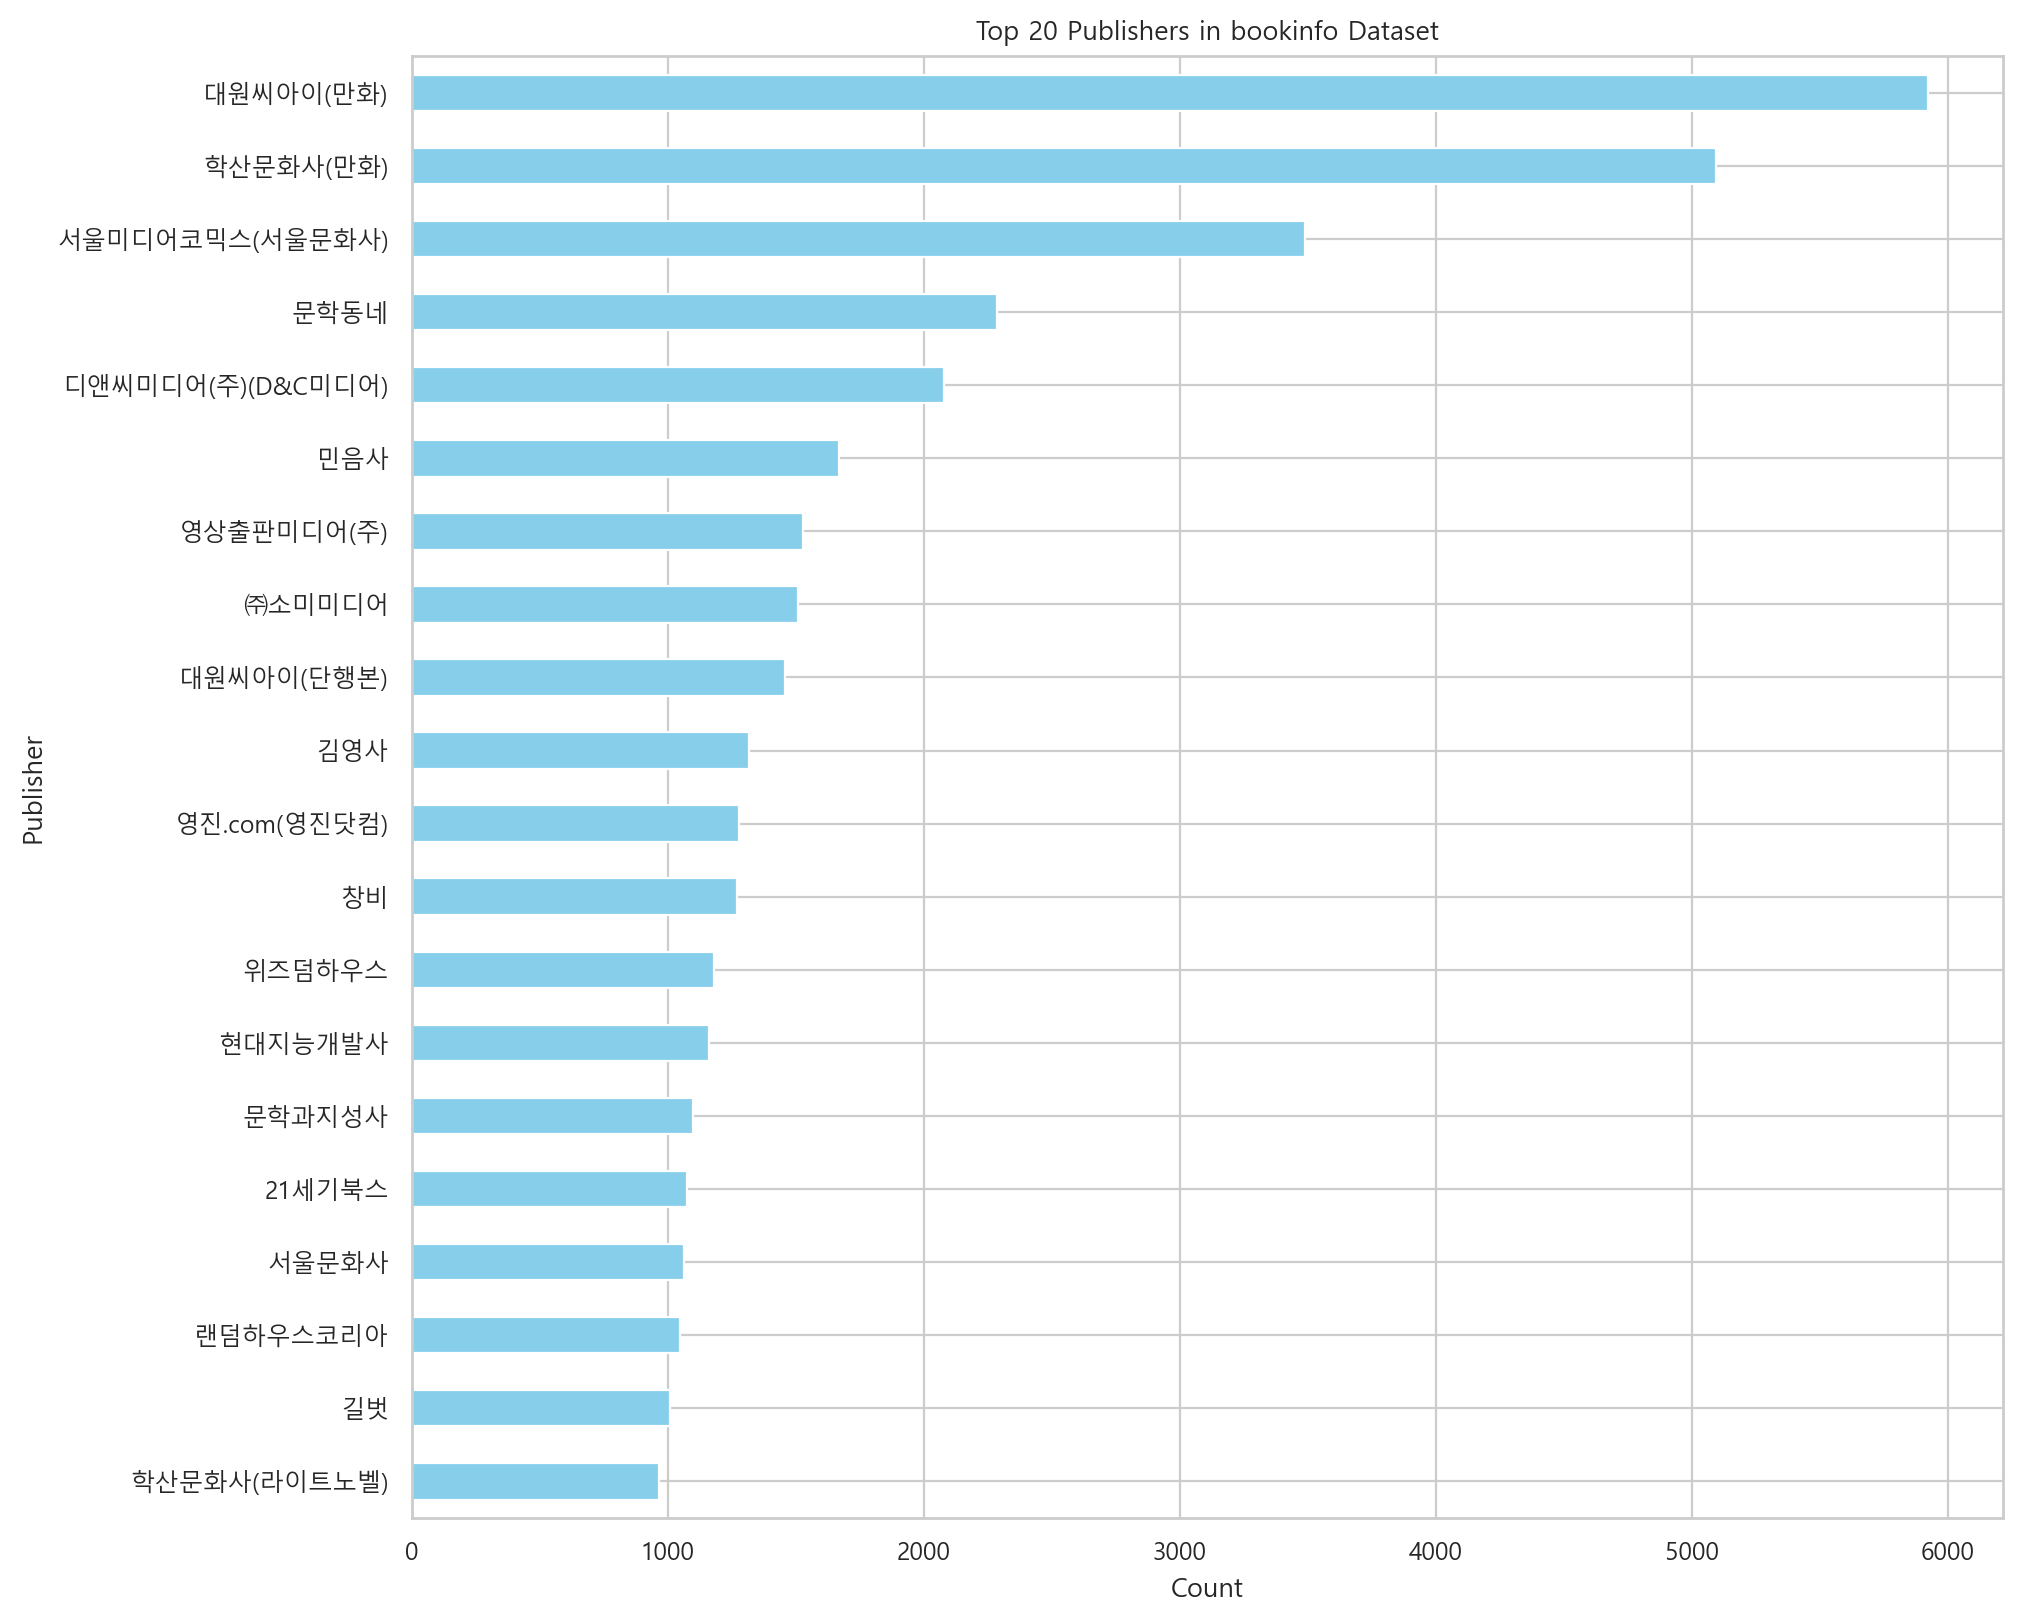

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming bookinfo.Publshr.value_counts() result is stored in a variable
publisher_counts = bookinfo['Publshr'].value_counts()

# Selecting the top 20 publishers for better visualization
top_publishers = publisher_counts.head(20)

# Plotting
plt.figure(figsize=(10, 8))
top_publishers.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Publisher')
plt.title('Top 20 Publishers in bookinfo Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()

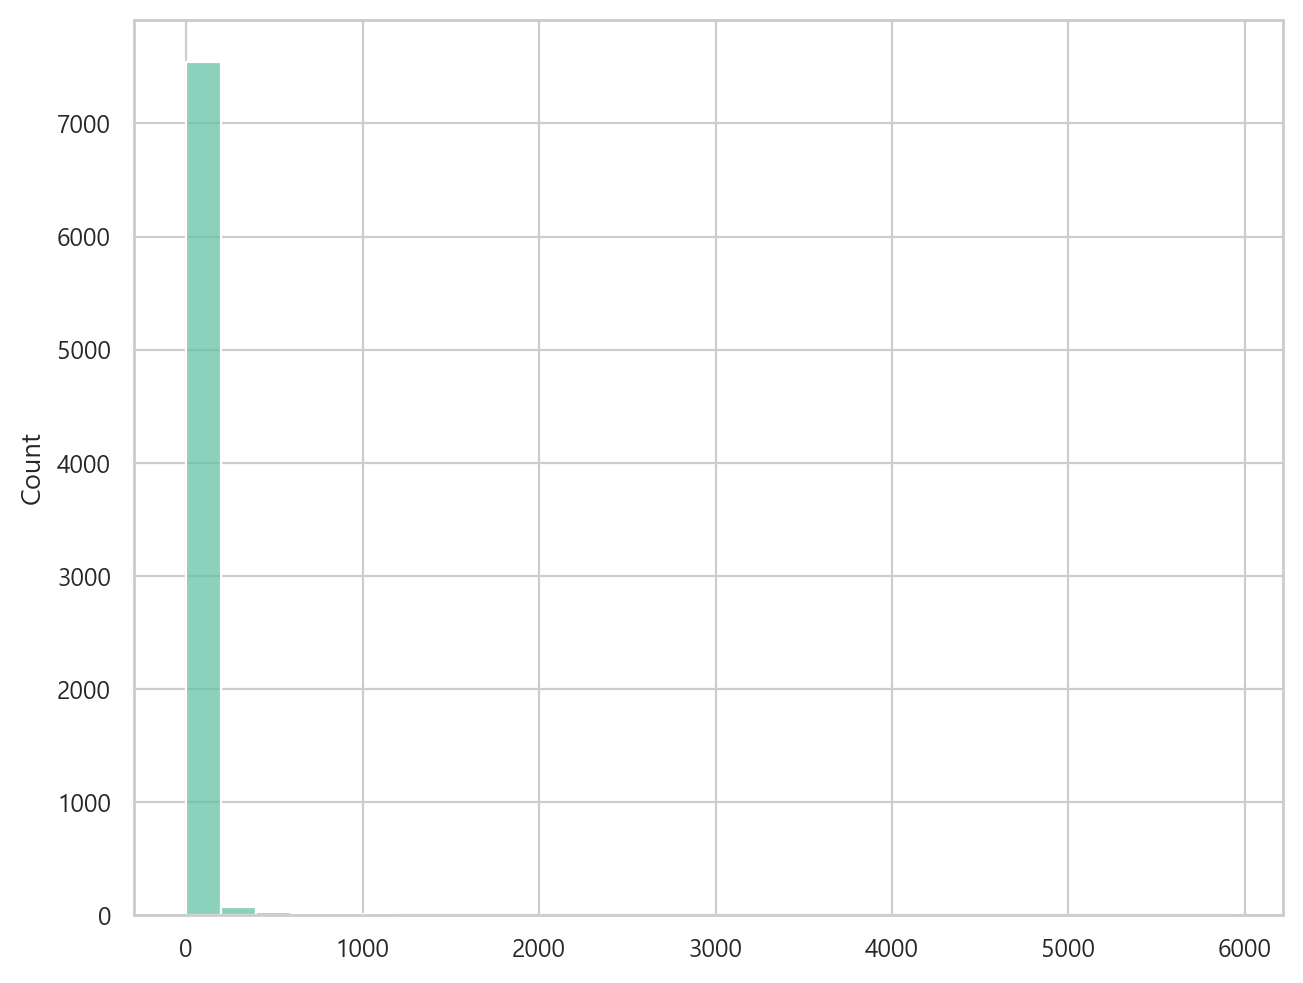

In [114]:
sns.histplot(bookinfo.Publshr.value_counts().values,bins=30);

In [115]:
stats = bookinfo.Publshr.value_counts()
cond = stats > 10
stats[cond]

Publshr
대원씨아이(만화)            5922
학산문화사(만화)            5097
서울미디어코믹스(서울문화사)      3491
문학동네                 2288
디앤씨미디어(주)(D&C미디어)    2080
                     ... 
주변인의길                  11
두란노키즈                  11
카멜북스                   11
이화문화출판사                11
한미의학                   11
Name: count, Length: 1818, dtype: int64

In [116]:
stats = bookinfo.Publshr.value_counts()
cond = stats >= 20
stats[cond]

Publshr
대원씨아이(만화)            5922
학산문화사(만화)            5097
서울미디어코믹스(서울문화사)      3491
문학동네                 2288
디앤씨미디어(주)(D&C미디어)    2080
                     ... 
송송책방                   20
Gbrain(지브레인)           20
홍릉(홍릉과학출판사)            20
우리출판사(서울출판)            20
퍼플카우콘텐츠그룹              20
Name: count, Length: 1150, dtype: int64

In [117]:
stats.iloc[0:50]

Publshr
대원씨아이(만화)            5922
학산문화사(만화)            5097
서울미디어코믹스(서울문화사)      3491
문학동네                 2288
디앤씨미디어(주)(D&C미디어)    2080
민음사                  1668
영상출판미디어(주)           1529
㈜소미미디어               1510
대원씨아이(단행본)           1457
김영사                  1319
영진.com(영진닷컴)         1278
창비                   1270
위즈덤하우스               1181
현대지능개발사              1162
문학과지성사               1098
21세기북스               1074
서울문화사                1064
랜덤하우스코리아             1046
길벗                   1007
학산문화사(라이트노벨)          967
시대고시기획                949
시공사                   922
에듀윌                   879
열린책들                  747
웅진지식하우스               725
두란노                   686
알에이치코리아(RHK)          685
규장(규장문화사)             654
에스티유니타스               611
황금가지                  597
시공사(만화)               590
해냄                    580
한즈미디어(한스미디어)          544
학지사                   536
박문각                   532
한겨레출판                 524
넥서스                   510
한길사                   493
길찾기 

- 상위 50위 기준으로 ths 만들어서 선택
- 분류 별로 하는 것을 확인해보는 것도 가능할 듯
- 출판사 명에 괄호가 있는 것 때문에 같은 출판사가 다르게 등록된 것은 없는지 확인

#### 분류

In [118]:
bookinfo.Category.value_counts()

Category
소설/시/희곡      29790
만화           23201
수험서/자격증      11608
인문학           9636
경제경영          9372
종교/역학         8901
에세이           8006
자기계발          6886
사회과학          6718
대학교재/전문서적     6218
외국어           5685
예술/대중문화       4781
역사            4577
컴퓨터/모바일       4387
건강/취미         3886
청소년           3346
좋은부모          3147
과학            2882
요리/살림         2829
여행            1735
고전             233
달력/기타          181
어린이             64
유아              23
일본 도서            3
전집/중고전집          2
청소년_추천도서         2
교육/자료            1
Name: count, dtype: int64

- token들 numbering할 때 제목, roles과 합쳐서 하면 될 듯

#### 저서 명
- \[\], \(\)로 되어있는 패턴들은 다 필터
- 수합해서 내용 확인

In [186]:
patterns=dict()
patterns['['] = r'\[+[^\[\]]+\]+'
patterns['{'] = r'\{+[^\{\}]+\}+'
patterns['('] = r'\(+[^\(\)]+\)+'

def re_iter_to_rslt(re_iter):
    return {
        m.start() : m.group()
        for m in re_iter
    }
    
def find_patterns(patterns,sentence):
    return {
        key : re_iter_to_rslt(re.finditer(pat,sentence.strip()))
        for key,pat in patterns.items()
    }

In [140]:
sent = '[신간] 최고 인기 [[안녕하세요]] 환영합니다'
temp = re.finditer(patterns['['],sent)

In [141]:
display(temp.__sizeof__())
for m in temp:
#    display(m.__dir__())
    display(m.group())
    display(m.groups())
    display(m.groupdict())
    display(m.start())
    display(m.end())
    display(m.pos)
    break

32

'[신간]'

()

{}

0

4

0

In [146]:
titles = bookinfo['BName']

In [187]:
import itertools

temp = titles.apply(lambda x : find_patterns(patterns,x))
display(temp.iloc[0])
display(list(map(len,list(temp.iloc[0].values()))))
display(sum(list(map(len,list(temp.iloc[0].values())))))

{'[': {}, '{': {}, '(': {}}

[0, 0, 0]

0

In [188]:
display(sum(map(len,temp.iloc[-1].values())))

1

In [189]:
count_all_ele = lambda x: sum(map(len,x.values()))
cond = temp.apply(count_all_ele)>0
temp[cond]

67            {'[': {}, '{': {}, '(': {15: '(교재 + 테이프)'}}
101                  {'[': {}, '{': {}, '(': {7: '(합본)'}}
162                  {'[': {}, '{': {}, '(': {5: '(양장)'}}
180            {'[': {}, '{': {}, '(': {7: '(교재 + 칠교판)'}}
193        {'[': {}, '{': {}, '(': {12: '(교재 + 테이프 3개)'}}
                              ...                        
9286                 {'[': {}, '{': {}, '(': {7: '(양장)'}}
9299    {'[': {}, '{': {}, '(': {14: '(기출지문 암기 App 이용쿠...
9303             {'[': {}, '{': {}, '(': {13: '(최신개정판)'}}
9306               {'[': {}, '{': {}, '(': {12: '(한정판)'}}
9327               {'[': {}, '{': {}, '(': {13: '(양장본)'}}
Name: BName, Length: 883, dtype: object

In [211]:
def clear_patterns(patterns:dict,sentence):
    for pat in patterns.values() :
        sentence = re.sub(pat,'',sentence).strip()
        sentence = re.sub(r'\s+',' ',sentence).strip()
    return sentence

In [212]:
sent = '[신간] 최고 인기 [[안녕하세요]] 환영합니다 [(안녕)]하세요'
temp = re.finditer(patterns['['],sent)
display(find_patterns(patterns,sent))
re.sub(patterns['['],'',sent)

{'[': {0: '[신간]', 11: '[[안녕하세요]]', 27: '[(안녕)]'}, '{': {}, '(': {28: '(안녕)'}}

' 최고 인기  환영합니다 하세요'

In [213]:
display(clear_patterns(patterns,sent))

'최고 인기 환영합니다 하세요'

In [214]:
display(titles)
display(titles.apply(lambda x : clear_patterns(patterns,x)))

0               민병철 생활영어 1
1                  행복에의 초대
2               훈련으로 되는 제자
3                   전태일 평전
4                    제자의 삶
               ...        
9323            장송의 프리렌 12
9324            약사의 혼잣말 13
9325      타몬 군 지금 어느 쪽?! 7
9326           천재 의사 시건방 1
9327    전지적 루이&후이 시점 (양장본)
Name: BName, Length: 9328, dtype: object

0             민병철 생활영어 1
1                행복에의 초대
2             훈련으로 되는 제자
3                 전태일 평전
4                  제자의 삶
              ...       
9323          장송의 프리렌 12
9324          약사의 혼잣말 13
9325    타몬 군 지금 어느 쪽?! 7
9326         천재 의사 시건방 1
9327        전지적 루이&후이 시점
Name: BName, Length: 9328, dtype: object

- 권 정보는 따로 분리 안해도 될 듯

## 정리하여 적용
- 저자명 : 1저자만 추출
    - ```extract_author1``` 사용
    - 공저자 등이 있는지에 대한 bool columns을 만듦
- 도서명 : 괄호 안의 내용 분리
    - 각 괄호 별로 들어있는 내용을 추출한 뒤 ', '.join
- 출판사 : 상위 50개를 제외하고는 기타 처리
- 대분류 : 별도의 처리 하지 않되 token 코퍼스에 추가

In [215]:
bookinfo

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
0,322.0,국내도서,민병철 생활영어 1,54947,9788975121036,13740.0,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,270점,177.0,외국어,2001년1월3주
1,767.0,국내도서,행복에의 초대,168173,9788932852218,93230.0,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,20점,1960.0,종교/역학,2005년2월1주
2,449.0,국내도서,훈련으로 되는 제자,458277,9788937501791,NaN,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,220점,552.0,종교/역학,2005년2월1주
3,490.0,국내도서,전태일 평전,128759,9788971990650,NaN,조영래 지음,돌베개,1983-06-01,6000,6000,60점,409.0,사회과학,2001년1월3주
4,300.0,국내도서,제자의 삶,131488,9788937502590,3230.0,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,360점,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,국내도서,장송의 프리렌 12,342597187,9791141131623,NaN,"야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,10530.0,만화,2024년7월2주
9324,138.0,국내도서,약사의 혼잣말 13,342597589,9791141137175,NaN,"네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성",학산문화사(만화),2024-07-25,6000,5400,300점,5870.0,만화,2024년7월2주
9325,129.0,국내도서,타몬 군 지금 어느 쪽?! 7,342597714,9791141131678,NaN,"시와스 유키 지음, 최윤정 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,6370.0,만화,2024년7월2주
9326,209.0,국내도서,천재 의사 시건방 1,342388828,9791160342147,74810,"강효미 지음, 유영근 그림",머스트비,2024-07-31,13000,11700,650점,8190.0,어린이,2024년7월2주


In [217]:
bookinfo.columns

Index(['Rank', 'Partition', 'BName', 'ItemId', 'ISBN13', 'AddCode', 'Author',
       'Publshr', 'Pdate', 'RglPrice', 'SlsPrice', 'Mileage', 'SalesPoint',
       'Category', 'Sorce'],
      dtype='object')

In [231]:
bookinfo_processed = bookinfo.copy()
cols = ['Rank','BName','ItemId','Author',
       'Publshr','Pdate','RglPrice','SlsPrice','SalesPoint',
       'Category','Sorce'] 
bookinfo_processed = bookinfo_processed[cols]

In [232]:
import itertools

titles = bookinfo['BName']
temp = titles.apply(lambda x : find_patterns(patterns,x))
temp2 = pd.DataFrame(data = [np.nan]*len(temp),index = temp.index)
for parens in patterns.keys():
    temp2[f'con_{parens}'] = temp.apply(lambda x: ', '.join(list(x[parens].values())))

paren_cols = list(map(lambda x : f'con_{x}',patterns.keys()))
bookinfo_processed['BName_sub'] = temp2[paren_cols].apply(lambda x : ', '.join(
    (filter(lambda y : y !='',x))),axis=1)
bookinfo_processed['BName'] = titles.apply(lambda x : clear_patterns(patterns,x))

bookinfo_processed

,Rank,BName,ItemId,Author,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce,BName_sub
0,322.0,민병철 생활영어 1,54947,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,177.0,외국어,2001년1월3주,
1,767.0,행복에의 초대,168173,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주,
2,449.0,훈련으로 되는 제자,458277,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주,
3,490.0,전태일 평전,128759,조영래 지음,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주,
4,300.0,제자의 삶,131488,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주,
...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,342597187,"야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김",학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주,
9324,138.0,약사의 혼잣말 13,342597589,"네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성",학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주,
9325,129.0,타몬 군 지금 어느 쪽?! 7,342597714,"시와스 유키 지음, 최윤정 옮김",학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주,
9326,209.0,천재 의사 시건방 1,342388828,"강효미 지음, 유영근 그림",머스트비,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주,


In [241]:
bookinfo_processed['BName_sub'].value_counts()

BName_sub
                      8445
(양장)                    50
(반양장)                   27
(무선)                    22
(스프링)                   20
                      ... 
(2014~2015년 최신개정판)       1
(2015년용)                 1
(2014년)                  1
(60만 부 기념 스페셜 에디션)       1
(2024 하편)                1
Name: count, Length: 493, dtype: int64

In [238]:
k = 50
stats = bookinfo['Publshr'].value_counts().sort_values(ascending=False)
top_k_val = stats.iloc[k]
publs_top_k = list(stats[stats >= top_k_val].index)
len(publs_top_k)
#top k 정하는 것은 완전 합본 후에 정해야 함

52

In [240]:
cond_etc = ~(bookinfo['Publshr'].isin(publs_top_k))
bookinfo_processed.loc[cond_etc,'Publshr'] =  '기타 출판사'
display(len(bookinfo_processed['Publshr'].unique()))
display(bookinfo_processed['Publshr'].value_counts())

53

Publshr
기타 출판사               5576
대원씨아이(만화)             220
학산문화사(만화)             216
문학동네                  210
서울미디어코믹스(서울문화사)       169
민음사                   167
해커스어학연구소(Hackers)     146
창비                    145
길벗                    125
위즈덤하우스                122
김영사                   121
영진.com(영진닷컴)           96
문학과지성사                 93
열린책들                   87
21세기북스                 86
디앤씨미디어(주)(D&C미디어)      81
에스티앤북스(ST&BOOKS)       80
㈜소미미디어                 73
에스티유니타스                71
해냄                     64
웅진지식하우스                62
에듀윌                    61
랜덤하우스코리아               58
알에이치코리아(RHK)           56
영상출판미디어(주)             52
넥서스                    51
두란노                    49
한길사                    47
서울문화사                  46
한겨레출판                  46
은행나무                   45
황금가지                   45
현대지능개발사                44
까치                     43
다산북스                   42
메가스터디교육(공무원)           42
비즈니스북스                 39
쌤앤파커스                  39
시공사 

In [242]:
authors = bookinfo['Author']
cond_mul = authors.str.split(',').apply(len) > 1
bookinfo_processed['Author'] = authors.apply(extract_author1)
bookinfo_processed['Author_mul'] = cond_mul

bookinfo_processed

,Rank,BName,ItemId,Author,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce,BName_sub,Author_mul
0,322.0,민병철 생활영어 1,54947,민병철,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주,,False
1,767.0,행복에의 초대,168173,IVP(한국기독학생회출판부) 편집부,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주,,False
2,449.0,훈련으로 되는 제자,458277,월터 A. 헨릭슨,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주,,False
3,490.0,전태일 평전,128759,조영래,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주,,False
4,300.0,제자의 삶,131488,프랜시스 M.코스그로브,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,342597187,야마다 카네히토,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주,,True
9324,138.0,약사의 혼잣말 13,342597589,네코쿠라게,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주,,True
9325,129.0,타몬 군 지금 어느 쪽?! 7,342597714,시와스 유키,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주,,True
9326,209.0,천재 의사 시건방 1,342388828,강효미,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주,,True


In [245]:
new_cols = cols.copy()
new_cols.insert(4,'Author_mul')
new_cols.insert(2,'BName_sub')
display(new_cols)
bookinfo_processed = bookinfo_processed[new_cols]
display(bookinfo_processed)

['Rank',
 'BName',
 'BName_sub',
 'ItemId',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
 'SlsPrice',
 'SalesPoint',
 'Category',
 'Sorce']

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
0,322.0,민병철 생활영어 1,,54947,민병철,False,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주
1,767.0,행복에의 초대,,168173,IVP(한국기독학생회출판부) 편집부,False,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주
2,449.0,훈련으로 되는 제자,,458277,월터 A. 헨릭슨,False,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주
3,490.0,전태일 평전,,128759,조영래,False,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주
4,300.0,제자의 삶,,131488,프랜시스 M.코스그로브,False,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,,342597187,야마다 카네히토,True,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주
9324,138.0,약사의 혼잣말 13,,342597589,네코쿠라게,True,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주
9325,129.0,타몬 군 지금 어느 쪽?! 7,,342597714,시와스 유키,True,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주
9326,209.0,천재 의사 시건방 1,,342388828,강효미,True,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주


In [247]:
file_name = 'bookinfo_ver0.csv'
save_path = os.path.join(PRJCT_PATH,'processed',file_name)
bookinfo_processed.to_csv(save_path,index=False)